In [3]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import scipy

In [4]:
def initialize_weights(row,col):   
    return tf.Variable(tf.random.uniform(shape=(row,col),maxval=0.4,minval=0)),\
            tf.Variable(tf.random.uniform(shape=(col,1),maxval=0,minval=0))


In [5]:
def activation_relu(z):
    zeros = tf.zeros_like(z)
    return tf.maximum(z,zeros)

In [6]:
def sigmoid(z):
    return (tf.Variable(1.0) / (tf.Variable(1.0) + tf.math.exp(-z)))

In [7]:
def phi(W,b,X):
    return (tf.transpose(W) @ X) + b

In [8]:
def soft_max(z): # (4,50) (4,150) (50,1)
    z = tf.transpose(z)
    s = tf.math.reduce_max(z, axis=1)
    s = tf.expand_dims(s,axis=1) 
    e_x = tf.math.exp(z-s)
    denum = tf.reduce_sum(e_x, axis=1)
    denum = tf.expand_dims(denum,axis=1)
    output = tf.transpose(e_x / denum)
    # print(s)
    # print(z-s)
    # print(e_x)
    # print(denum)
    return output


In [9]:
z = np.array([[2.0],  [1.0]])
soft_max(z)

2023-04-12 10:59:41.969887: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-12 10:59:41.970263: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-12 10:59:41.970303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hasti-zen): /proc/driver/nvidia/version does not exist
2023-04-12 10:59:41.971931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[0.73105858],
       [0.26894142]])>

In [10]:
def forward_propagation(weight,X,y): # 4 - 50 - 50 - 3
    out1 = activation_relu(phi(weight['wl1'],weight['bl1'],X)) # (50,150)
    out2 = activation_relu(phi(weight['wl2'],weight['bl2'],out1)) # (50,150)
    outf = soft_max(phi(weight['wl3'],weight['bl3'],out2)) # (3,150)
    # cost = tf.reduce_mean((y-outf)**2)
    cost = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(tf.transpose(y),tf.transpose(outf)))
    return cost,outf

In [11]:
def back(weight,X,y):
    with tf.GradientTape() as tape:
        out1 = activation_relu(phi(weight['wl1'],weight['bl1'],X)) 
        out2 = activation_relu(phi(weight['wl2'],weight['bl2'],out1))
        outf = soft_max(phi(weight['wl3'],weight['bl3'],out2))
        # cost = tf.reduce_mean((y-outf)**2)
        cost = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(tf.transpose(y),tf.transpose(outf)))
        print(cost)
        all_weights = [i for i in weight.values()]
        dw3,db3,dw2,db2,dw1,db1 = tape.gradient(cost,all_weights)
        return {'dw3':dw3, 'db3':db3, 'dw2':dw2, 'db2':db2, 'dw1':dw1, 'db1':db1}


In [12]:
def update_weights(lamb,weight,grads,X,y):
    for i in range(2000):
        grads = back(weight,X,y)
        weight['wl3'].assign_sub(lamb * grads['dw3'])
        weight['bl3'].assign_sub(lamb * grads['db3'])
        weight['wl2'].assign_sub(lamb * grads['dw2'])
        weight['bl2'].assign_sub(lamb * grads['db2'])
        weight['wl1'].assign_sub(lamb * grads['dw1'])
        weight['bl1'].assign_sub(lamb * grads['db1'])
    return weight



In [13]:
def compute_accuracy(y,pred):
    Y = np.argmax(y, axis = 1)
    Ypred = np.argmax(pred, axis = 1)
    accuracy = (Y == Ypred).sum()/Y.size
    return accuracy

In [14]:
data = pd.read_csv('./iris.data',names=['x1','x2','x3','x4','y'])
for col in ['x1','x2','x3','x4']:
    data[col] = (data[col] - data[col].mean()) / data[col].std()
data_shuffle = data.sample(frac=1)
datax = tf.convert_to_tensor(data_shuffle[['x1','x2','x3','x4']],dtype=tf.float32)
one_hot = pd.get_dummies(data_shuffle['y'])
datay = tf.convert_to_tensor(one_hot[['Iris-setosa','Iris-versicolor','Iris-virginica']],dtype=tf.float32)

split = 130

X = tf.transpose(datax[:split])
Y = tf.transpose(datay[:split])
Wl1,bl1 = initialize_weights(4,50) 
Wl2,bl2 = initialize_weights(50,50)
Wl3,bl3 = initialize_weights(50,3)
weights = {'wl3':Wl3,'bl3':bl3,'wl2':Wl2,'bl2':bl2,'wl1':Wl1,'bl1':bl1}

_,pred = forward_propagation(weights,X,Y)
grads = back(weights,X,Y)
new_weight = update_weights(0.2,weights,grads,X,Y)

_,pred_t = forward_propagation(new_weight,X,Y)

X_c = tf.transpose(datax[split:])
Y_c = tf.transpose(datay[split:])

_,pred_c = forward_propagation(new_weight,X_c,Y_c)


tf.Tensor(0.9653025, shape=(), dtype=float32)
tf.Tensor(0.9653025, shape=(), dtype=float32)
tf.Tensor(2.3577108, shape=(), dtype=float32)
tf.Tensor(1.3004428, shape=(), dtype=float32)
tf.Tensor(5.481101, shape=(), dtype=float32)
tf.Tensor(0.9633905, shape=(), dtype=float32)
tf.Tensor(5.0576468, shape=(), dtype=float32)
tf.Tensor(1.5569931, shape=(), dtype=float32)
tf.Tensor(0.7741161, shape=(), dtype=float32)
tf.Tensor(2.8311198, shape=(), dtype=float32)
tf.Tensor(2.0629218, shape=(), dtype=float32)
tf.Tensor(1.7167579, shape=(), dtype=float32)
tf.Tensor(1.6911755, shape=(), dtype=float32)
tf.Tensor(1.6547258, shape=(), dtype=float32)
tf.Tensor(1.6271658, shape=(), dtype=float32)
tf.Tensor(1.589232, shape=(), dtype=float32)
tf.Tensor(1.5181618, shape=(), dtype=float32)
tf.Tensor(1.4742659, shape=(), dtype=float32)
tf.Tensor(1.4336575, shape=(), dtype=float32)
tf.Tensor(1.3548813, shape=(), dtype=float32)
tf.Tensor(1.2198318, shape=(), dtype=float32)
tf.Tensor(1.0515262, shape=(), dtype

In [15]:
print(compute_accuracy(tf.transpose(Y),tf.transpose(pred_t)))

1.0


In [16]:
print(compute_accuracy(tf.transpose(Y_c),tf.transpose(pred_c)))

0.9


In [17]:
class convers_pca():
    def __init__(self, no_of_components):
        self.no_of_components = no_of_components
        self.eigen_values = None
        self.eigen_vectors = None
        self.projection_matrix = None

    def transform(self, x):
        return np.dot(x, self.projection_matrix.T)

    def fit(self, x):

        U,sigma,V = np.linalg.svd(x,full_matrices=False,compute_uv=True)
        self.eigen_values = np.square(sigma)/(x.shape[0]-1)
        self.eigen_vectors = V.T

        self.sorted_components = np.argsort(self.eigen_values)[::-1]

        self.projection_matrix = self.eigen_vectors[self.sorted_components[:self.no_of_components]]


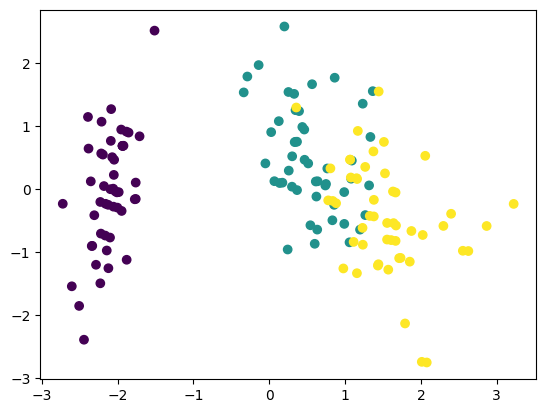

In [18]:

datax = tf.convert_to_tensor(data[['x1','x2','x3','x4']],dtype=tf.float32)

pca = convers_pca(no_of_components = 2)
pca.fit(datax)
dim_red = pca.transform(datax)
labels = data['y']
int_lab = []
for i in labels:
    if i == 'Iris-setosa':
        int_lab.append(1)
    if i == 'Iris-versicolor':
        int_lab.append(2)
    if i == 'Iris-virginica':
        int_lab.append(3)    
plt.figure()
plt.scatter(dim_red[:,0], dim_red[:,1], c=int_lab)

In [19]:
class LDA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.eigen_values = None
        self.eigen_vectors = None
        self.projection_matrix = None

    def fit(self, X, y):
        n_features = X.shape[1]
        labels = np.unique(y)

        # Within class scatter matrix:
        # SW = sum((X_c - mean_X_c)^2 )

        # Between class scatter:
        # SB = sum( n_c * (mean_X_c - mean_overall)^2 )

        mean_overall = np.mean(X, axis=0)
        S_w = np.zeros((n_features, n_features))
        S_b = np.zeros((n_features, n_features))
        for c in labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            S_w += (X_c - mean_c).T.dot((X_c - mean_c))

            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            S_b += n_c * (mean_diff).dot(mean_diff.T)

        A = np.dot(np.linalg.pinv(S_w), S_b)
        self.eigen_values, self.eigen_vectors = np.linalg.eig(A)
        self.eigen_vectors = self.eigen_vectors.T

        sorted_components = np.argsort(self.eigen_values)[::-1]

        self.projection_matrix = self.eigen_vectors[sorted_components[:self.n_components]]

    def transform(self, X):
        # project data
        return np.dot(X, self.projection_matrix.T)

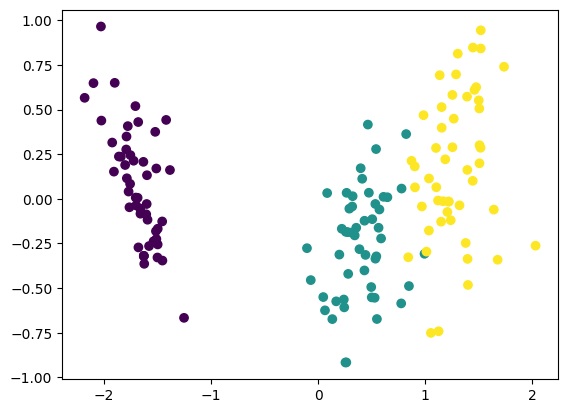

In [20]:
x = np.array(data[['x1','x2','x3','x4']])
y = np.array(data['y'])
lda = LDA(n_components = 2)
lda.fit(x, y)
dim_red = lda.transform(datax)
labels = data['y']
int_lab = []
for i in labels:
    if i == 'Iris-setosa':
        int_lab.append(1)
    if i == 'Iris-versicolor':
        int_lab.append(2)
    if i == 'Iris-virginica':
        int_lab.append(3)    
plt.figure()
plt.scatter(dim_red[:,0], dim_red[:,1], c=int_lab)